# Titanic - Machine learning from disaster

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Rutas

In [2]:
train = "/content/drive/MyDrive/Data/titanic/train.csv"
test = "/content/drive/MyDrive/Data/titanic/test.csv"
submission = "/content/drive/MyDrive/Data/titanic/Resultados/"

## Configuraciones basicas

In [3]:
np.random.seed(0)
plt.rcParams['figure.figsize'] = [8, 5]

## Exploracion basica

In [4]:
df_train = pd.read_csv(train)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Separacion del dataframe

In [6]:
X = df_train[["Pclass", "Sex", "Age", "Fare", "Embarked", "SibSp", "Parch"]].copy()
y = df_train["Survived"].copy()

## Transformadores

In [7]:
class Numericas(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    imputador = SimpleImputer(strategy="median")
    escalador = StandardScaler()
    X["Age"] = imputador.fit_transform(X["Age"].values.reshape(-1, 1))
    X["Fare"] = imputador.fit_transform(X["Fare"].values.reshape(-1, 1))
    X["Fare"] = escalador.fit_transform(X["Fare"].values.reshape(-1, 1))
    return X

In [8]:
class Categoricas(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    imputador = SimpleImputer(strategy="most_frequent")
    X["Pclass"] = imputador.fit_transform(X["Pclass"].astype("str").values.reshape(-1, 1))
    X["Sex"] = imputador.fit_transform(X["Sex"].values.reshape(-1, 1))
    X["Embarked"] = imputador.fit_transform(X["Embarked"].values.reshape(-1, 1))
    X["SibSp"] = imputador.fit_transform(X["SibSp"].values.reshape(-1, 1))
    X["Parch"] = imputador.fit_transform(X["Parch"].values.reshape(-1, 1))
    dummies = pd.get_dummies(X[["Pclass", "Sex", "Embarked", "SibSp", "Parch"]])
    X = X.drop(columns=["Pclass", "Sex", "Embarked", "SibSp", "Parch"])
    X = pd.concat([X, dummies], axis=1)
    return X

## Pipeline para transformacion de datos

In [9]:
pipeline_data = make_pipeline(
                               Numericas(),
                               Categoricas()
)

## Pipelines para comparacion de modelos

In [10]:
p_lr = Pipeline([
    ("data", pipeline_data),
    ("LR", LogisticRegression(max_iter=5000))
])
p_knc = Pipeline([
    ("data", pipeline_data),
    ("KNC", KNeighborsClassifier())
])
p_dtc = Pipeline([
    ("data", pipeline_data),
    ("DTC", DecisionTreeClassifier())
])
pipes = (p_lr, p_knc, p_dtc)

In [11]:
comparativa = []
for i in pipes:
  comparativa.append(
      cross_val_score(
          i,
          X,
          y,
          scoring = "roc_auc",
          cv = 10
      ).mean()
  )
comparativa

[0.8533779532014826, 0.8207660357072122, 0.7519097133803017]

## Busqueda de parametros optimos

In [12]:
lr_params = {
    "C" : [0.1, 0.5, 0.9],
    "fit_intercept" : [True, False],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter" : [5000],
    "multi_class" : ["auto", "ovr"],
}
knc_params = {
    "n_neighbors" : [5, 10, 15],
    "weights" : ["uniform", "distance"],
    "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size" : [25, 50, 100]
}
dtc_params = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_features" : ["auto", "sqrt", "log2"] 
}

In [13]:
grid_search_lr = GridSearchCV(LogisticRegression(), lr_params)
grid_search_lr.fit(pipeline_data.fit_transform(X), y)
grid_search_lr.best_estimator_

LogisticRegression(C=0.1, max_iter=5000, solver='newton-cg')

In [14]:
grid_search_knc = GridSearchCV(KNeighborsClassifier(), knc_params)
grid_search_knc.fit(pipeline_data.fit_transform(X), y)
grid_search_knc.best_estimator_

KNeighborsClassifier(leaf_size=50)

In [15]:
grid_search_dtc = GridSearchCV(DecisionTreeClassifier(), dtc_params)
grid_search_dtc.fit(pipeline_data.fit_transform(X), y)
grid_search_dtc.best_estimator_

DecisionTreeClassifier(max_features='log2', splitter='random')

## Comparacion de modelos optimizados

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3
)

In [17]:
pipeline_final_lr = Pipeline([
                           ("Data", pipeline_data),
                           ("LR", LogisticRegression(
                               C=0.1, max_iter=5000, solver="newton-cg"
                           ))
])
pipeline_final_knc = Pipeline([
                           ("Data", pipeline_data),
                           ("KNC", KNeighborsClassifier(
                               leaf_size=50
                           ))
])
pipeline_final_dtc = Pipeline([
                           ("Data", pipeline_data),
                           ("DTC", DecisionTreeClassifier(
                              max_features='log2', splitter="random"
                           ))
])
pf_list = [pipeline_final_lr, pipeline_final_knc, pipeline_final_dtc]

In [18]:
resultados_grid_search = []
resultados_normales = []
for i in pf_list:
  resultados_grid_search.append(cross_val_score(
      i,
      X_train,
      y_train,
      cv=10,
      scoring="roc_auc"
  ).mean())
for i in pipes:
  resultados_normales.append(cross_val_score(
      i,
      X_train,
      y_train,
      cv=10,
      scoring="roc_auc"
  ).mean())
resultados_cv = {"SearchGrid" : resultados_grid_search,
                 "Normales" : resultados_normales}
resultados_cv

{'Normales': [0.84624100537144, 0.7875926700111482, 0.7269606389986825],
 'SearchGrid': [0.8478173456977804, 0.7866613459004763, 0.7423191572919834]}

## Graficas para comparar modelos

In [19]:
def plots(y_test, preds):
  ConfusionMatrixDisplay.from_predictions(y_test, preds)
  PrecisionRecallDisplay.from_predictions(y_test, preds)
  RocCurveDisplay.from_predictions(y_test, preds)
  print(accuracy_score(y_test, preds, normalize = True))
  plt.plot()

0.7761194029850746


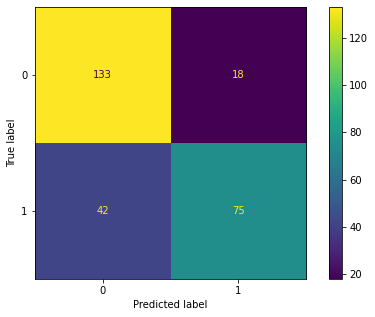

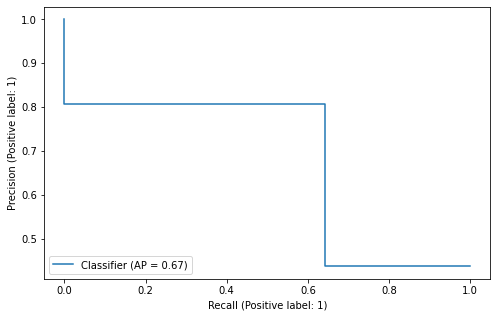

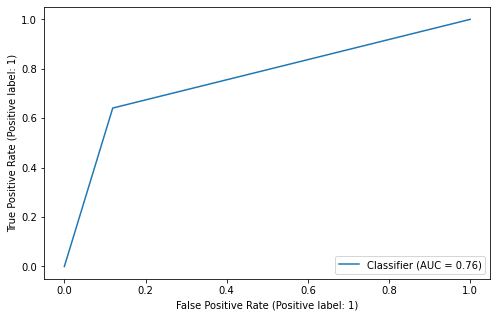

In [20]:
modelo_lr = pipeline_final_lr.fit(X_train, y_train)
preds_lr = modelo_lr.predict(X_test)
plots(y_test, preds_lr)

0.75


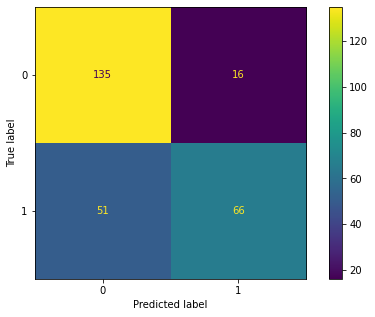

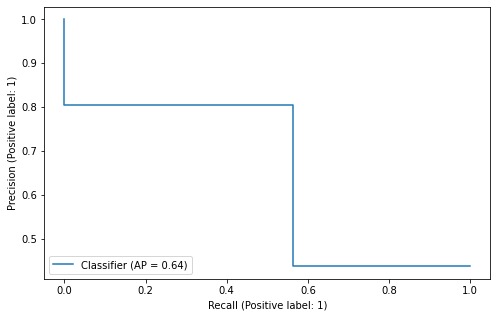

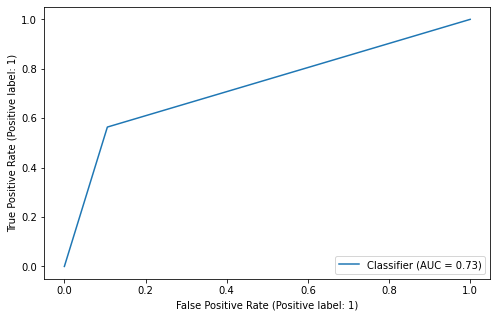

In [21]:
modelo_knc = pipeline_final_knc.fit(X_train, y_train)
preds_knc = modelo_knc.predict(X_test)
plots(y_test, preds_knc)

0.7388059701492538


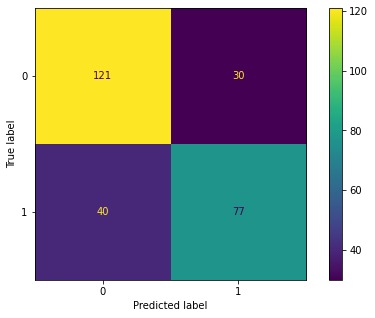

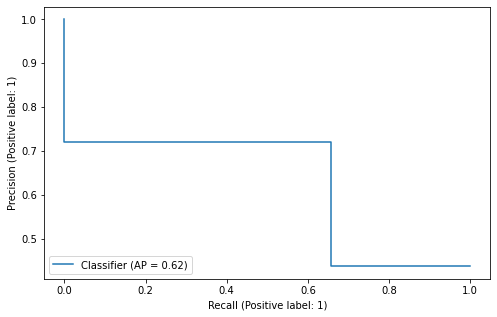

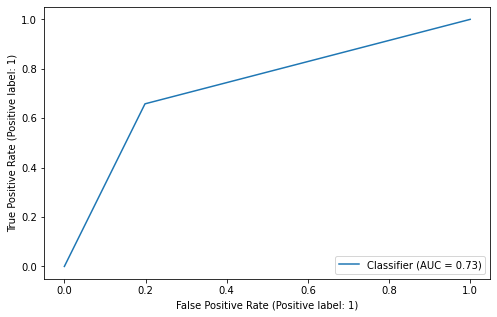

In [22]:
modelo_dtc = pipeline_final_dtc.fit(X_train, y_train)
preds_dtc = modelo_dtc.predict(X_test)
plots(y_test, preds_dtc)

## Se exportan los csv con las predicciones

In [23]:
def export(pipeline, nombre):
  df_test = pd.read_csv(test)
  modelo_final = pipeline.fit(X, y)
  resultados_finales = modelo_final.predict(df_test[["Pclass", "Sex", "Age", "Fare", "Embarked", "SibSp", "Parch"]].copy())
  csv = {"PassengerID" : df_test["PassengerId"],
       "Survived" : resultados_finales}
  csv = pd.DataFrame(csv)
  csv.to_csv(str(submission) + nombre + ".csv", index = False)

In [24]:
export(pipeline_final_lr, "logistic")
export(pipeline_final_knc, "neighbors")
export(pipeline_final_dtc, "tree")